##  Project 3: Collaboration and Competition

# Goal and Enviroment

In the project, I built agents that will collaborate on tennis playing task. Details could be seen from [ReadMe](https://https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/README.md) 

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The environment is considered solved, when the average (over 100 episodes) of maximum of each agent's scores is at least +0.5.

# Learning Algorithm

During the project I adopted the highly suggested *multi-agent deep deterministic policy gradient* (MADDPG) algorithm. The algorithm used is based on a natural extension of the DDPG algorithms described in these papers:

* [MADDPG](https://arxiv.org/pdf/1706.02275.pdf)

* [DDPG](https://arxiv.org/pdf/1509.02971.pdf)

Details of these algorithms are below:

## Theoretical Foundation of MADDPG

### Actor-Critic Method and DDPG

In general, one can use a policy based method to optimize the policy gradient directly. Actor-critic methods leverage the strengths of both policy-based and value-based methods. Using a policy-based approach, the agent (actor) learns how to act by directly estimating the optimal policy and maximizing reward through gradient ascent. Meanwhile, employing a value-based approach, the agent (critic) learns how to estimate the value (i.e., the future cumulative reward) of different state-action pairs. Actor-critic methods combine these two approaches in order to accelerate the learning process. Actor-critic agents are also more stable than value-based agents, while requiring fewer training samples than policy-based agents. The detailed algorithm for DDPG is already elaborated during [last project](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p2_continuous-control/Report.ipynb).

In this environment the agents interact cooperatively and they have identical capabilities, and so a single DDPG agent could have been trained to play both agents rather than MADDPG. One version of such implementation can be found at the [Github](https://github.com/tommytracey/DeepRL-P3-Collaboration-Competition).

However, there are a number of important applications that involve interaction between multiple agents, where emergent behavior and complexity arise from agents co-evolving together. Unfortunately, traditional reinforcement learning approaches such as Q-Learning or policy gradient are poorly suited to multi-agent environments. One issue is that each agent's policy is changing
as training progresses, and the environment becomes non-stationary from the perspective of any individual agent (in a way that is not explainable by changes in the agent's own policy). This presents learning stability challenges and prevents the straightforward use of past experience replay, which is crucial for stabilizing deep Q-learning. Policy gradient methods, on the other hand, usually exhibit very high variance when coordination of multiple agents is required. Alternatively, one can use model based policy optimization which can learn optimal policies via back-propagation, but this requires a (differentiable) model of the world dynamics and assumptions about the interactions between agents. Applying these methods to competitive environments is also challenging from an optimization perspective, as evidenced by the notorious instability of adversarial training methods.


### Multi-Agent Actor Critic

A multi-agent setting introduces several additional complexities. For example, from the perspective of a single agent, it is tempting to view other agents as part of the environment,as if they merely receive an action and output a state response. We have argued in the previous section that naïve policy gradient methods perform poorly in simple multi-agent settings. 

In 2017, OpenAI published a new [breakthrough](https://openai.com/blog/learning-to-cooperate-compete-and-communicate/) on multi-agent RL. The MADDPG [paper](https://arxiv.org/pdf/1706.02275.pdf) introduces the concept of centralized training but de-centralized execution as a work-around for this problem. 

In their work, they propose a general-purpose multi-agent learning algorithm that: (1) leads to learned policies that only use local information (i.e. their own observations) at execution time, (2) does not assume a differentiable model of the environment dynamics or any particular structure on the communication method between agents, and (3) is applicable not only to cooperative interaction but to competitive or mixed interaction involving both physical and communicative behavior. The ability to act in mixed cooperative-competitive environments may be critical for intelligent agents; while competitive training provides a natural curriculum for learning, agents must also exhibit cooperative behavior (e.g. with humans) at execution time.

The paper adopts the framework of centralized training with decentralized execution, allowing the policies to use extra information to ease training, so long as this information is not used at test time. It is a simple extension of actor-critic policy gradient methods where the critic is augmented with extra information about the policies of other agents, while the actor only has access to local information. After training is completed, only the local actors are used at execution phase, acting in a decentralized manner and equally applicable in cooperative and competitive settings.

Essentially each critic is augmented to receive as inputs the actions and states of all other agents as well as it's own, and during updates utilized other agent's actors and target actors rather than viewing them as part of the environment. This omniscient critic is used to train the actor, by performing gradient ascent on the critic's evaluation of the actor's action. During execution outside of training though the actor is able to act freely without access to other agent's internal models.


More precisely, consider a game with N agents with policies parameterized by $\theta$, and let $\pi$ be the set of all agent policies. Then one can write the gradient of the expected return for agent $i$, $J(\theta_i) = \mathbb{E}[R_i]$ as:


$$ \nabla_{\theta_i} J(\theta_i) = \mathbb{E}[\nabla_{\theta_i} \log \pi_i (a_i | o_i) Q_i^\pi (x, a_1, ..., a_N) ]$$

Here $Q_i^\pi (x, a_1, ..., a_N)$ is a centralized action-value function that takes as input the actions of all agents, in addition to some state information x, and outputs the Q-value for agent i. In the simplest case, x could consist of the observations of all agents, however we could also include additional state information if available. Since each $Q^π_i$ is learned separately, agents can have arbitrary reward structures, including conflicting rewards in a competitive setting.

We extend the above idea to work with deterministic policies. If we now consider N continuous policies $\mu_{\theta_i}$ w.r.t. parameters $\theta_i$, the gradient can be written as:

$$ \nabla_{\theta_i} J(\mu_i) = \mathbb{E}[\nabla_{\theta_i} \mu_i (a_i | o_i) \nabla_{a_i} Q_i^\mu (x, a_1, ..., a_N)|_{a_i=\mu_i(o_i)}] $$


The centralized action-value function $ Q_i^\mu$ is updated according to:

$$\mathcal{L} = \mathbb{E}[(Q_i^\mu (x, a_1, ..., a_N) - y )^2], $$
where $ y = R_i+ \gamma Q_i^{\mu'} (x', a_1', ..., a_N')$. $\mu'$ here is the set of target policies with delayed parameters $\theta_i'$.
      

Please find the DDPG logic implemented as part of the `MADDPG()` class in [`maddpg.py`](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/maddpg.py#L30) of the source code. The networks $\mu$ and $Q$ can be found via their respective `Network(actor=True)` and `Network(actor=False)` classes [networkforall.py](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/networkforall.py).

Note that in the paper MADDPG also includes some other additions, such as prioritized experience replay and policy ensembles, which were not used in this implementation. 

#### Experience Replay
Experience replay allows the RL agent to learn from past experience.

As with DDPG in the previous project, MADDPG also utilizes a replay buffer to gather experiences from each agent. Each experience is stored in a replay buffer as the agent interacts with the environment. In this project, there is one central replay buffer utilized by both agents, therefore allowing agents to learn from each others' experiences.  

The replay buffer contains a collection of experience tuples with the state, action, reward, and next state $(s, a, R, s')$. Each agent samples from this buffer as part of the learning step. Experiences are sampled randomly, so that the data is uncorrelated. This prevents action values from oscillating or diverging catastrophically, since a naive algorithm could otherwise become biased by correlations between sequential experience tuples.

Also, experience replay improves learning through repetition. By doing multiple passes over the data, our agents have multiple opportunities to learn from a single experience tuple. This is particularly useful for state-action pairs that occur 
infrequently within the environment.

The implementation of the replay buffer can be found in the [`buffer.py`](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/buffer.py) of the source code.

Also, the size of the buffer is also very important to the success of the training. Initially I was using the default buffer size 1e5, however, it reached the target performance very slow with this size. Finally, I changed the size to 4e4 and reached the performances shown in this report. 

#### Exploration vs Exploitation
One challenge is choosing which action to take while the agent is still learning the optimal policy. Should the agent choose an action based on the rewards observed thus far? Or, should the agent try a new action in hopes of earning a higher reward? This is known as the **exploration vs. exploitation dilemma**.

In this project, we encourage the exploration in two stages. In the first 100 episodes, we will execute a pure random policy before the learning process get started. Secondly, we'll use the same **Ornstein-Uhlenbeck process**, as suggested in the previously project to solve this dilemma during the training. The Ornstein-Uhlenbeck process adds a certain amount of noise to the action values at each time step. This noise is correlated to previous noise, and therefore tends to stay in the same direction for longer durations without canceling itself out. This allows the rackets to maintain momentum and explore the action space with more continuity.

You can find the Ornstein-Uhlenbeck process implemented  in the class of [`OUNoise.py`](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/OUNoise.py) from the source code.

# Code Implementation

The code used here is adapted from the ["Physical Deception Lab"](https://classroom.udacity.com/nanodegrees/nd893/) tutorial from the Deep Reinforcement Learning Nanodegree, and has been adjusted for being used with the Tennis Environment.

The code consist of :

- `networkforall.py` : In this python file, a PyTorch `Network()` class are implemented which inherits nn.Module base class. This is a regular fully connected Deep Neural Network using the [PyTorch Framework](https://pytorch.org/docs/0.4.0/). The actor network will be trained to generate the actions to perform depending on the environment observed states while the critic network will be trained to evaluate the advantage of such actions. These Neural Networks are used by the DDPG agent and is composed of :

  - Actor network
      - by setting `actor=True` in the constructor
      - input layer of size equal to the `input_dim` (24)
      - 2 hidden fully connected layers of `hidden_in_dim` and `hidden_out_dim` cells each
      - output layer which returns the actions to be taken by the agent, depends on the `action_size` parameter passed in the constructor, which is 2 in our problem
      
  - Critic network
      - by setting `actor=False` in the constructor
      - input layer of `input_dim` (48)
      - 1st hidden fully connected layers of `hidden_in_dim` cells with **4** extra units sourcing the action values
      - 2nd hidden fully connected layers of `hidden_out_dim` cells
      - output layer which returns the Q-value of size 1
  

- `maddpg.py` : In this python file, a MADDPG agent is defined.

    - The `MADDPG` class is implemented, as described in the DDPG algorithm. It provides several methods :
  
    - `__init__()` (constructor): 
      - Initialize 2 instance of the `DDPGAgent` (see below), representing the two tennis players in the problem
      - sourcing in the discount factor for $\gamma$, and $\tau$
      
    - `act()`:
      - It returns actions for the given state as per current policy (actor) network 
      - Add noise to each step the actor is taking
      
    - `target_act()`:
      - It returns actions for the given state as per current target policy (actor) network 
      - It is off-policy which will ignore the noise added to the true actions. 
      
    - `update()`:
      - which update both agents' critic and actor Neural Network value parameters by standard training procedure using given batch of experiences from the Replay Buffer
      
    - `update_targets()`:
      - update the two *target* networks' weights with continuous blending from the current weight values from the *local* network with parameter `self.tau`


- `ddpg_agent.py` : In this python file, a `DDPGAgent` is defined.

  - The `DDPGAgent` class is implemented, as described in the DDPG algorithm. It provides several methods :
    - `__init__ ()` constructor : 
      - Initialize the OUNoise instance
      - Initialize 2 instance of the Actor  Neural Network : the *target* network and the *local* network
      - Initialize 2 instance of the Critic Neural Network : the *target* network and the *local* network
      - Initialize the target networks the be same as the local networks
      - Initialize the optimizer for local networks
      
    - `act()`:
      - It returns actions for the given state as per current policy (actor) network 
      - Add noise to each step the actor is taking
      
    - `target_act()`:
      - It returns actions for the given state as per current target policy (actor) network 
      - It is off-policy which will ignore the noise added to the true actions. 


- `buffer.py` : 

  - The ReplayBuffer class implements a fixed-size buffer to store experience tuples  (state, action, reward, next_state, done) 
    - `push()` allows to add an experience step to the memory
    
    - `sample()` allows to randomly sample a minibatch of experience steps for the learning  


- `OUNoise.py` : 

  - The OUNoise class implements Ornstein-Uhlenbeck process to serve an exploration mechanism for the action 
    - `reset()` allows to reset the internal state (= noise) to mean (`self.mu`)
    
    - `noise()` allows to randomly return a noise sample to be added to the action
    
    
- `main_tennis.py` : This python file is the main entry to the problem, which allows to train the agent. Moreover, it allows to :
  - Import the Necessary Packages 
  - Examine the State and Action Spaces
  - Take Random Actions in the Environment
  - Train an agent using `MADDPG()` class, the main function of training is called `update()`
  - Use Tensorboard and Progressbar to monitor the training procedure
  - Plot the scores


# MADDPG Parameters and Results

## Hyperparameters

### DDPG Agents

In total, there are six hyper-parameters related to the DDPG Agent itself. The hyperparameters of the agent are listed as below:

```python

Actor_LAYER_1 = 512    # size of 1st fully connected layer in the actor network
Actor_LAYER_2 = 256    # size of 2nd fully connected layer in the actor network
Critic_LAYER_1 = 512   # size of 1st fully connected layer in the critic network
Critic_LAYER_2 = 256   # size of 2nd fully connected layer in the critic network

lr_actor  = 1.0e-2      # learning rate of the actor 
lr_critic = 1.0e-3      # learning rate of the critic
WEIGHT_DECAY = 0.0001   # exponential decay rate for moment estimates in Adam

GAMMA = 0.99            # discount factor for Q value calculation
TAU   = 1e-2            # for soft update of target parameters
```
Note that in principle one can use different network structure for actor and critic network. Here, to reduce some complexity of the system I have used the same structure for both networks and the sizes listed above turned out to be enough to generate good performance. 

To reduce the variance of future steps in the TD(1) evaluation, I have reduced the discount rate from 0.99 to 0.98 which receives a good effect. 

The two learning rate was the major hyper-parameters for me to tune. In order to get a well guided direction for the tuning, I leverage the [tensorboard](https://pytorch.org/docs/stable/tensorboard.html) capability within PyTorch. Details can be found in the next subsection.



### Replay Buffer Hyperparameters
The Replay Buffer has two hyperparameters that determine the size of the buffer and sample size of the minibatch:
```python
buffersize = int(5e4)   # replay buffer size
batchsize  = 512        # minibatch size
```

As indicated in the previous section, the size of the buffer was tuned to have enough samples which is a critical point.

### OUNoise Hyperparameters
The Ornstein-Uhlenbeck process itself has three hyperparameters that determine the noise characteristics and magnitude:
- mu: the long-running mean
- theta: the speed of mean reversion
- sigma: the volatility parameter

Of these, I only tuned sigma and theta. After running a few experiments, I reduced sigma from 0.2 to 0.1. The reduced noise volatility seemed to help the model converge faster.

Notice also there's an epsilon parameter used to decay the noise level over time. I got this idea from [Remy Hamilton-Smith](https://github.com/Remtasya/Distributional-Multi-Agent-Actor-Critic-Reinforcement-Learning-MADDPG-Tennis-Environment/blob/master/Report.md), although I should say it is a natural adaption from the magnitude of $\epsilon$-greedy policy. This decay mechanism ensures that more noise is introduced earlier in the training process (i.e., higher exploration), and the noise decreases over time as the agent gains more experience (i.e., higher exploitation). The decay rate of OU Noise is tuned during experimentation. Also, the decaying of the noise scale is controlled in such a way that we only decrease the noise while there are signs of score improvement. Lastly, we also control the minimum scale of noise to ensure, there is always a little exploration left no matter what. The minimum bound of the noise scale is set at 0.05 as shown below. 

You can find the epsilon process implemented [here](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/main_tennis.py#L198) in the `main_tennis.py` of the source code. 

The final noise parameters were set as follows:

```python
NOISE_SIGMA = 0.1              # Ornstein-Uhlenbeck noise vol parameter
NOISE_THETA = 0.1              # Ornstein-Uhlenbeck noise speed parameter
EPSILON_DECAY = 0.998          # decay rate for noise process
noise_low_threshold = 0.05     # lower bound for the noise scale decay multiplier 
```

The noise scale profile can be seen from the following image:
![Noise Scale](images/noise_scale.png)



## Model Tuning and Monitoring

Admittedly, this is a harder project to crack down. I have used significantly more effort than the first two projects did to reach the performance that was satisfactory. Some of them are due to my personal work and life constraints. More are attributed to the notorious complex nature of the problem. 

As is well known in the AI community, all the AI programs would experience two stage of debugging: code debug and hyper-parameters debug. In terms of code debugging, it is relatively easy and straight forward, although time consuming, there are well developed tools and general practices to follow. It took only a day to adapt codes from the Physical Deception lab to run without problems in the current settings. 

However, hyper-parameter tunning/debugging is a much more complicated process. As counted from above, we have 15 hyper-parameters to tune in this project and not each and everyone had the same effect on the final outcome. And initially one has no clue of what is a more important parameter to tune. To gain insight about the training process I used the following code to launch a Tensorboard environment:

```python
%tensorboard --logdir logs 
```

One can see in tensorboard that different training iterations are put into different folder and shown in different colors. In each iteration, I ran episodes up to **10k**, and the episode number is indicated on the horizontal axis.

To facilitate the process, I added several tensorboard logger at different places of the codes. For example, the noise scale logger would reveal the plots shown above. Next, I monitor the detail actions of the agent took to see what kind action spaces have been covered, as can be seen [here](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/main_tennis.py#L75). Furthermore, I have noted down the loss functions of the actor and the critic network to see how the losses are minimized during the training, as shown [here](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/main_tennis.py#L155). 

Initially, I was using the same learning rate for the actor and the critic. However, after noticing that the critic loss function has some large swings, I lowered the learning rate for the critic and thus achieved much better and stable training. 
These tensorboard logging functions gave me tremendous help on the direction for tuning hyper-parameters. The detail tuning processes facilitated by those metrics will be discussed below. 

Let us now have a detail look at the loss functions.


### Critic Losses

The grey line shows the agent0's critic loss function, while the blue one shows that for agent1. Note that the two agents' loss functions are pretty similar and steadily decreasing. This symbolize that the learning rate for critic Network is appropriate, at least not too high. 

<img src="images/critic_losses.png" width=400 />

### Actor Losses

The orange line shows the agent0's actor loss function, while the red one shows that for agent1. Note that the two agents' loss functions are again showing similar patterns. Initially, the loss functions are increasing. The most interesting thing I learned from this project is that I need to be patient with the training process. For a long time the MADDPG agent could not reach the target performance and I almost lost confidence in the implementation. However, At around episode 8k, there is a kink in the actor's loss function, at which point the actor loss functions start to decrease and agents start to rapidly pick up the score (as can be seen from the result section). 


<img src="images/actor_losses.png" width=400 />

# Results

##  Model Results

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
event_acc = EventAccumulator("./log_final/events.out.tfevents.final")
event_acc.Reload()
w_times, step_nums, vals = zip(*event_acc.Scalars('result/final_metric'))

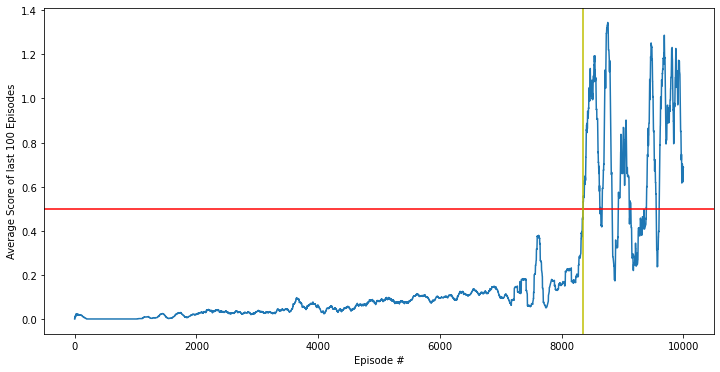

In [18]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.plot(step_nums, vals)
plt.axhline(y=0.5, color = 'r')
plt.axvline(x=8350, color = 'y')
plt.ylabel('Average Score of last 100 Episodes')
plt.xlabel('Episode #')
plt.show()

The final metric as indicated in the [README](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/README.md) of the project, and also implemented [here](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/main_tennis.py#L197) in the code, can be plotted as above. One can see above that the problem is solved at around episode 8350. 

In [22]:
print(vals[8350])

0.5044000148773193


## Final Model Performance

The final pytorch model results for MADDPG are stored in the `model_final` folder. The performance of the model can be accessed from the [`trained_agent`](https://github.com/readerwei/Reinforcement_Learning_Degree/blob/master/p3_collab-compet/trained_agent.ipynb) notebook. The bottom line is that using the trained smart agent, one can easily get a score of 
**1.9** for one episode. 

Note that one can watch the real time smart agent playing tennis by setting `train_mode=False` in the code. 

# Ideas for Future Work

## MADDPG Algorithm

### Expedite the training process

Although I have been trying my best to seek the best model to make my agent reach the target performance as soon as possible, it still took almost 8500 episodes to solve the problem. On the other hand, other [people](https://github.com/Remtasya/Distributional-Multi-Agent-Actor-Critic-Reinforcement-Learning-MADDPG-Tennis-Environment/blob/master/Report.md) claims that they could solve the problem much faster. I ran at least 30 different combinations in searching for a good set of hyperparameters, so perhaps implementing a more systemic approach such as grid search would help. On the other hand, the extreme high dimensionality of the parameter space would prevent such a brute force grid search and thus more insights needs to be shed on the training process. 

### Add prioritized experience replay  

Rather than selecting experience tuples randomly, prioritized replay selects experiences based on a priority value that is correlated with the magnitude of error. This can improve learning by increasing the probability that rare or important experience vectors are sampled.

### Add policy ensembles

As previously mentioned, a recurring problem in multi-agent reinforcement learning is the environment non-stationarity due to the agents’ changing policies. This is particularly true in competitive settings, where agents can derive a strong policy by overfitting to the behavior of their competitors. Such policies are undesirable as they are brittle. To obtain multi-agent policies that are more robust to changes in the policy of competing agents, there are proposals to train a collection of K different sub-policies. At each episode, one may randomly select one particular sub-policy for each agent to execute. 


## Additional Multi-Agent Algorithm

Apart from MADDPG Algorithms, there are several other significantly important advances in the field of MARL as listed in the paper of [*Multi-Agent Reinforcement Learning: A Selective Overview of Theories and Algorithms*](https://arxiv.org/pdf/1911.10635.pdf), I should also try to implement algorithms there.